## Download Dataset from here:

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp


Emotion_Detection_Data/
├── train.txt
├── val.txt
└── test.txt

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

/home/amir/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Load data ---

def load_data(path):
    texts, labels = [], []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if ";" in line:
                text, label = line.strip().rsplit(";", 1)
                texts.append(text)
                labels.append(label)
    return texts, labels

train_texts, train_labels = load_data("Emotion_Detection_Data/train.txt")
val_texts, val_labels = load_data("Emotion_Detection_Data/val.txt")

In [3]:
# Encode labels

le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
val_labels_enc = le.transform(val_labels)
num_classes = len(le.classes_)

In [4]:
# Tokenize

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class EmotionDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        tokens = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=64, return_tensors="pt")
        return {
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx])
        }

train_ds = EmotionDataset(train_texts, train_labels_enc)
val_ds = EmotionDataset(val_texts, val_labels_enc)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

In [5]:
# Model

class EmotionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(output.pooler_output)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionClassifier().to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

train_accs, val_accs = [], []

In [6]:
# --- Train ---

for epoch in range(5):
    model.train()
    correct, total = 0, 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_accs.append(correct / total)

    # Evaluate on val
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_accs.append(correct / total)
    print(f"Epoch {epoch+1} - Train Acc: {train_accs[-1]:.2f}, Val Acc: {val_accs[-1]:.2f}")


Epoch 1 - Train Acc: 0.83, Val Acc: 0.93
Epoch 2 - Train Acc: 0.94, Val Acc: 0.94
Epoch 3 - Train Acc: 0.95, Val Acc: 0.94
Epoch 4 - Train Acc: 0.96, Val Acc: 0.94
Epoch 5 - Train Acc: 0.96, Val Acc: 0.94


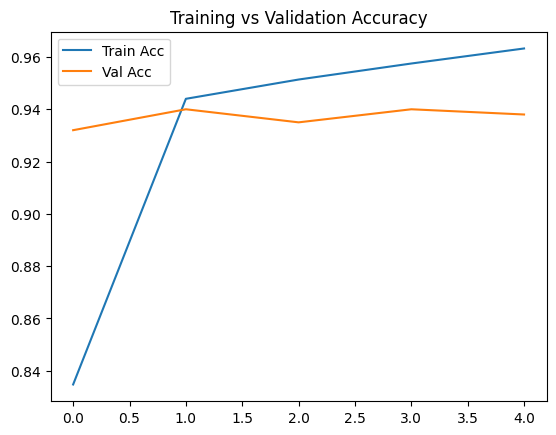

In [7]:
# --- Plot Accuracy ---

plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend(), plt.title("Training vs Validation Accuracy")
plt.show()

In [8]:
# --- Metrics ---

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=le.classes_))


Classification Report:
               precision    recall  f1-score   support

       anger       0.96      0.93      0.94       275
        fear       0.88      0.91      0.90       212
         joy       0.95      0.96      0.96       704
        love       0.89      0.84      0.86       178
     sadness       0.95      0.98      0.96       550
    surprise       0.97      0.75      0.85        81

    accuracy                           0.94      2000
   macro avg       0.93      0.90      0.91      2000
weighted avg       0.94      0.94      0.94      2000



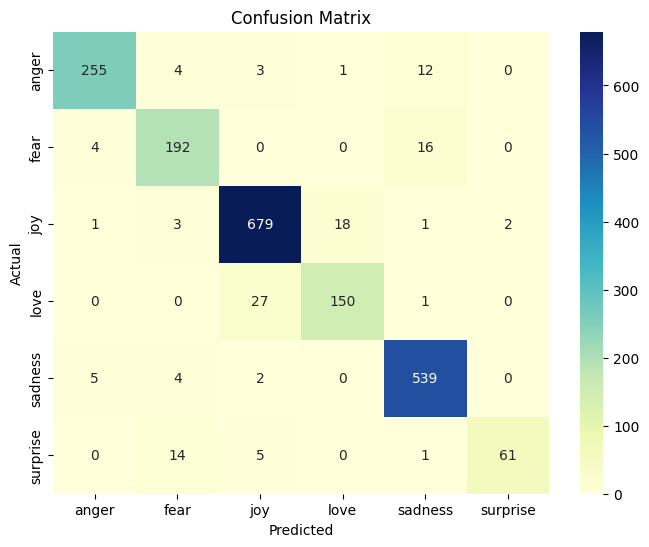

In [9]:
# Confusion Matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='YlGnBu')
plt.xlabel('Predicted'), plt.ylabel('Actual'), plt.title('Confusion Matrix')
plt.show()